**Introduction:**

Time series forecasting is a powerful technique for predicting future values of a target variable based on its past values. A time series dataset typically consists of a sequence of data points collected over time, with each data point representing a **measurement or observation** at a specific point in time.

Time series forecasting is different from other types of prediction problems because it involves analyzing the temporal patterns and trends in the data. This means that the order of the data points matters, and that there may be **seasonality, trends,residuals, and other patterns** that need to be accounted for in order to make accurate predictions.

**ML** models can be trained to automatically detect and account for variables that affect the target variable, such as promotions and special days, and can be used to generate accurate forecasts for a wide range of time series datasets.

**AIMs**

We aim to develop a flexible and scalable framework that can be applied to a wide range of time series datasets, while accounting for variables that can affect the target variable, and examining the relationship between ensemble techniques and forecasting error.

By combining the strengths of multiple ML models and techniques, we aim to achieve better forecasting performance and gain deeper insights into the underlying patterns and trends in the data.

**METHODOLOGY:**

1. Data Preprocessing: The first step is to prepare the time series dataset for analysis.

2. Stationarity Test: The next step is to test the time series for stationarity.

3. Determine Order of Differencing: If the time series is found to be non-stationary, the next step is to determine the order of differencing required to achieve stationarity.

4. Identify Order of AR and MA Terms: Once the time series is stationary, the next step is to identify the order of the autoregressive (AR) and moving average (MA) terms in the ARIMA model. This can be done by analyzing the autocorrelation and partial autocorrelation functions of the time series.

5. Fit ARIMA Model: With the order of differencing, AR and MA terms identified, the next step is to fit the ARIMA model to the time series data.

6. Model Diagnostics: After fitting the model, the next step is to evaluate its performance using diagnostic checks.

7. Forecasting:The accuracy of the forecasts can be evaluated using measures such as mean absolute error (MAE) or mean squared error (MSE).

8. Conclusion

In [300]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [301]:
!pip install pmdarima

In [302]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [303]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
store = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [304]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [305]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [306]:
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [307]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


# DATA PREPROCESSING

 We then merge the data into a single DataFrame:

In [308]:
train = train.merge(store, on ='store_nbr')
train = train.merge(oil, on ='date', how='left')
holidays_events = holidays_events.rename(columns={'type': 'holiday_type'})
train = train.merge(holidays_events, on='date', how='left')

In [309]:
train.fillna('', inplace=True)

In [310]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


# Data Analysis:

We will use store code 44, because it is the store that contains the highest number of sales. If we look at store size, we see that store 20 is in 9th place.

**Sales in holidays wise**

**calculate which store has maximum sales.**

In [311]:
num_stores = train['store_nbr'].nunique()
# Print the result
print("Total number of stores:", num_stores)

Total number of stores: 54


In [312]:
num_products = train['family'].nunique()
# Print the result
print("Total number of products:", num_products)

Total number of products: 33


In [313]:

num_state = train['state'].nunique()
# Print the result
print("Total number of states:", num_state)

Total number of states: 16


In [314]:
num_cities = train['city'].nunique()
# Print the result
print("Total number of cities:", num_cities)

Total number of cities: 22


In [315]:
# locale_name
num_locale_name = train['locale_name'].nunique()
# Print the result
print("Total number of locale_name:", num_locale_name)

Total number of locale_name: 25


In [316]:
from prettytable import PrettyTable
table = PrettyTable()

In [317]:

# Calculate the number of unique stores, products, states, cities, and locale_names
num_stores = train['store_nbr'].nunique()
num_products = train['family'].nunique()
num_state = train['state'].nunique()
num_cities = train['city'].nunique()
num_locale_name = train['locale_name'].nunique()

# Create a pretty table to display the results

table.field_names = ["Category", "Count"]
table.add_row(["Stores", num_stores])
table.add_row(["Products", num_products])
table.add_row(["States", num_state])
table.add_row(["Cities", num_cities])
table.add_row(["Locale Names", num_locale_name])

# Customize the table formatting
table.align["Category"] = "l"
table.align["Count"] = "r"
table.title = "Summary of Train Data"
table.title_style = "bold magenta"
table.header_style = "upper"
table.border_style = "double"
table.color_rows = ["red"]
table.color_border = "blue"

# Print the table
print(table)

+--------------+-------+
| CATEGORY     | COUNT |
+--------------+-------+
| Stores       |    54 |
| Products     |    33 |
| States       |    16 |
| Cities       |    22 |
| Locale Names |    25 |
+--------------+-------+


In [318]:
# train.groupby(['store_nbr'])['sales'].sum().sort_values(ascending=False).head()
# calculate which store has maximum sales.

# group the data by store_nbr and sum up the sales
sales_by_store = train.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)

# create a new DataFrame from the result
sales_table = pd.DataFrame({
    "store_nbr": sales_by_store.index,
    "total_sales": sales_by_store.values
})
print("The top 5 stores sales")
sales_table.head()

The top 5 stores sales


,store_nbr,total_sales
0,44,6.335614e+07
1,45,5.568902e+07
2,47,5.202448e+07
3,3,5.153353e+07
4,49,4.434682e+07


 **Which product has highest sales and least sales**

In [319]:
# group the data by product family and sum up the sales
sales_by_product = train.groupby("family")["sales"].sum().sort_values(ascending=False)


# sort the table in decreasing order by sales
print("The total sales of the product is:", sales_by_product)
# get the name of the product with the most sales
most_sold_product = sales_by_product.index[0]

print("The product with the most sales is:", most_sold_product)

The total sales of the product is: family
GROCERY I                     3.508273e+08
BEVERAGES                     2.216635e+08
PRODUCE                       1.254480e+08
CLEANING                      9.942102e+07
DAIRY                         6.582360e+07
BREAD/BAKERY                  4.295992e+07
POULTRY                       3.249445e+07
MEATS                         3.165100e+07
PERSONAL CARE                 2.510048e+07
DELI                          2.458563e+07
HOME CARE                     1.640952e+07
EGGS                          1.588120e+07
FROZEN FOODS                  1.464694e+07
PREPARED FOODS                8.966728e+06
LIQUOR,WINE,BEER              7.937172e+06
SEAFOOD                       2.051636e+06
GROCERY II                    2.004966e+06
HOME AND KITCHEN I            1.905076e+06
HOME AND KITCHEN II           1.556511e+06
CELEBRATION                   7.795020e+05
LADIESWEAR                    6.685420e+05
LINGERIE                      6.645950e+05
PLAYERS AND 

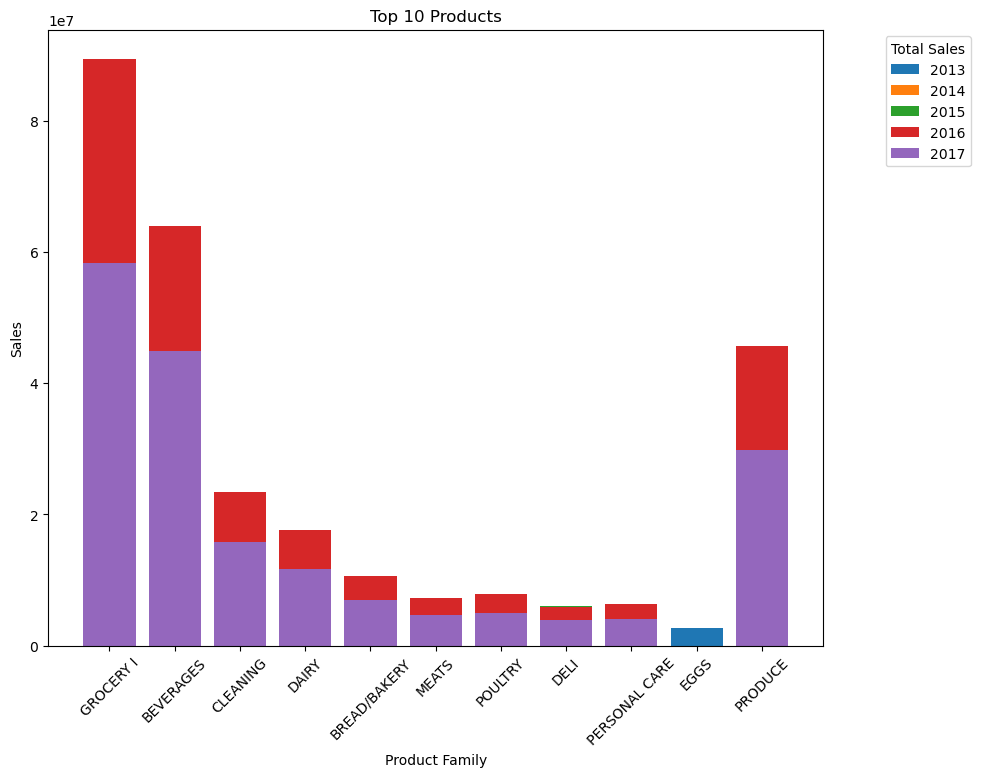

In [320]:
# convert the date column to datetime
train["date"] = pd.to_datetime(train["date"])
# extract the year from the date column
train["year"] = train["date"].dt.year

# group the data by year and product family and sum up the sales
sales_by_year_and_product = train.groupby(["year", "family"])["sales"].sum().reset_index()

# sort the data by year and sales in descending order
sales_by_year_and_product = sales_by_year_and_product.sort_values(by=["year", "sales"], ascending=[True, False])
fig, ax = plt.subplots(figsize=(10, 8))

# loop over the years and plot the top 10 products for each year
for year in sales_by_year_and_product["year"].unique():
    top_products = sales_by_year_and_product[sales_by_year_and_product["year"] == year].head(10)
    ax.bar(top_products["family"], top_products["sales"], label=str(year))

# set the axis labels and legend
ax.set_xlabel("Product Family")
ax.set_ylabel("Sales")
ax.legend(title="Total Sales", loc="upper right", bbox_to_anchor=(1.2, 1))

# rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# set the title and show the plot
ax.set_title("Top 10 Products")
plt.show()

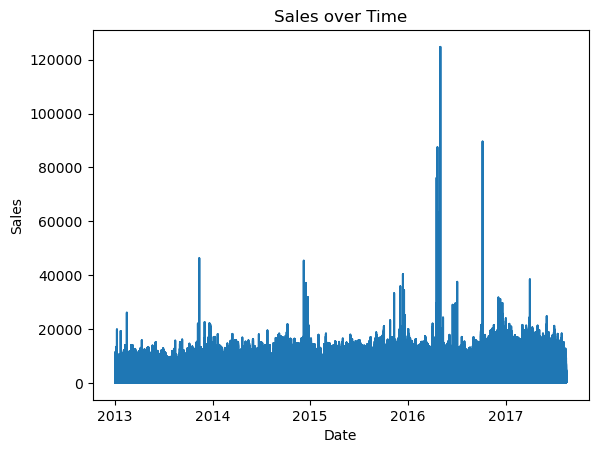

In [321]:
# Create a line chart
plt.plot(train['date'],train['sales'])

# Add title and axis labels
plt.title('Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Show the chart
plt.show()

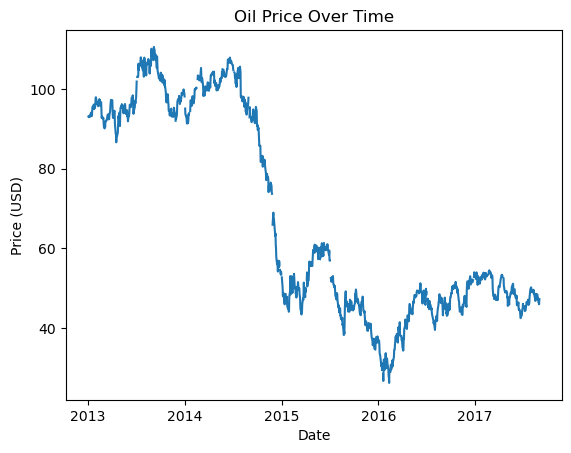

In [322]:
# Convert the 'date' column to a Pandas datetime object
oil['date'] = pd.to_datetime(oil['date'])

# Create a line plot of the oil price over time
plt.plot(oil['date'], oil['dcoilwtico'])

# Set the plot title and axis labels
plt.title('Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show the plot
plt.show()

 The resulting plot helps us visualize the trend and fluctuations in oil prices over time, which can provide valuable insights for analysis and decision-making.

We will filter all datasets with only top 5 store, since we want only top 5 stores

In [323]:
sales_by_store.describe()

count    5.400000e+01
mean     2.030694e+07
std      1.357171e+07
min      2.764970e+06
25%      1.137395e+07
50%      1.631321e+07
75%      2.534904e+07
max      6.335614e+07
Name: sales, dtype: float64

In [324]:
train['date'] = pd.to_datetime(train['date'])
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred,year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,,Holiday,National,Ecuador,Primer dia del ano,False,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017


As we can see, we haven't duplicate lines.

In [325]:
print("Rows: ", train.shape)
print("Remove duplicates rows:", train.drop_duplicates().shape)

Rows:  (3054348, 17)
Remove duplicates rows: (3054348, 17)


In [326]:
train = train.groupby('date')['sales','onpromotion'].sum().reset_index()
print(train)

           date          sales  onpromotion
0    2013-01-01    2511.618999            0
1    2013-01-02  496092.417944            0
2    2013-01-03  361461.231124            0
3    2013-01-04  354459.677093            0
4    2013-01-05  477350.121229            0
...         ...            ...          ...
1679 2017-08-11  826373.722022        14179
1680 2017-08-12  792630.535079         8312
1681 2017-08-13  865639.677471         9283
1682 2017-08-14  760922.406081         8043
1683 2017-08-15  762661.935939        10605

[1684 rows x 3 columns]


#  Stationarity testing and Determine Order of Differencing

**Testing the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test from the statsmodels library:**

In [327]:
# define the time series as a pandas Series
ts = train['sales']

In [328]:
from statsmodels.tsa.stattools import adfuller

# assuming your time series data is stored in a variable called 'ts'
result = adfuller(ts)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.931646
p-value: 0.041790
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


**Description**

The ADF statistic is a test statistic used in time series analysis to test for the presence of a unit root in a time series. A unit root implies that the series is non-stationary and its properties change over time, making it difficult to make reliable predictions.

In your case, the ADF statistic is -2.931646. This value indicates the strength of evidence against the null hypothesis of a unit root being present in the time series. The lower the ADF statistic, the stronger the evidence against the null hypothesis.

The p-value of 0.041790 is the probability of observing an ADF statistic as extreme as or more extreme than the observed value under the null hypothesis of a unit root. In other words, it tells you how likely it is that the ADF statistic is a result of random chance rather than a true indication of a non-stationary time series.

In this case, the p-value is less than 0.05, which means that we can reject the null hypothesis of a unit root with 95% confidence level, and conclude that the time series is stationary.

The critical values of the ADF test are provided for comparison with the observed ADF statistic. They indicate the threshold values that the ADF statistic needs to exceed in order to reject the null hypothesis of a unit root at different significance levels. In your case, the critical values at the 1%, 5%, and 10% levels are -3.434, -2.863, and -2.568, respectively. Since the observed ADF statistic is greater than the critical value at the 1% and 5% levels, we can reject the null hypothesis with 99% and 95% confidence, respectively.

<details>
    <summary>
        <font color = 'blue'><h1>About</h1></font>
    </summary>
    <p>

1. **The Augmented Dickey-Fuller (ADF) Statistic:** This measures the test statistic of the ADF test. It is a negative number, and the more negative it is, the stronger the evidence for rejecting the null hypothesis (i.e., the more likely the time series is stationary).

2. **p-value:** This measures the probability of observing the ADF statistic under the null hypothesis that the time series is non-stationary. The smaller the p-value, the stronger the evidence for rejecting the null hypothesis.

3. **Critical Values:** These are pre-defined thresholds for the ADF statistic beyond which we can reject the null hypothesis with a certain level of confidence. There are different critical values for different levels of significance (e.g., 1%, 5%, 10%). If the ADF statistic is lower than the critical values, we can reject the null hypothesis and conclude that the time series is stationary.

# Determine Order of Differencing

Text(0.5, 1.0, 'Residual Plot')

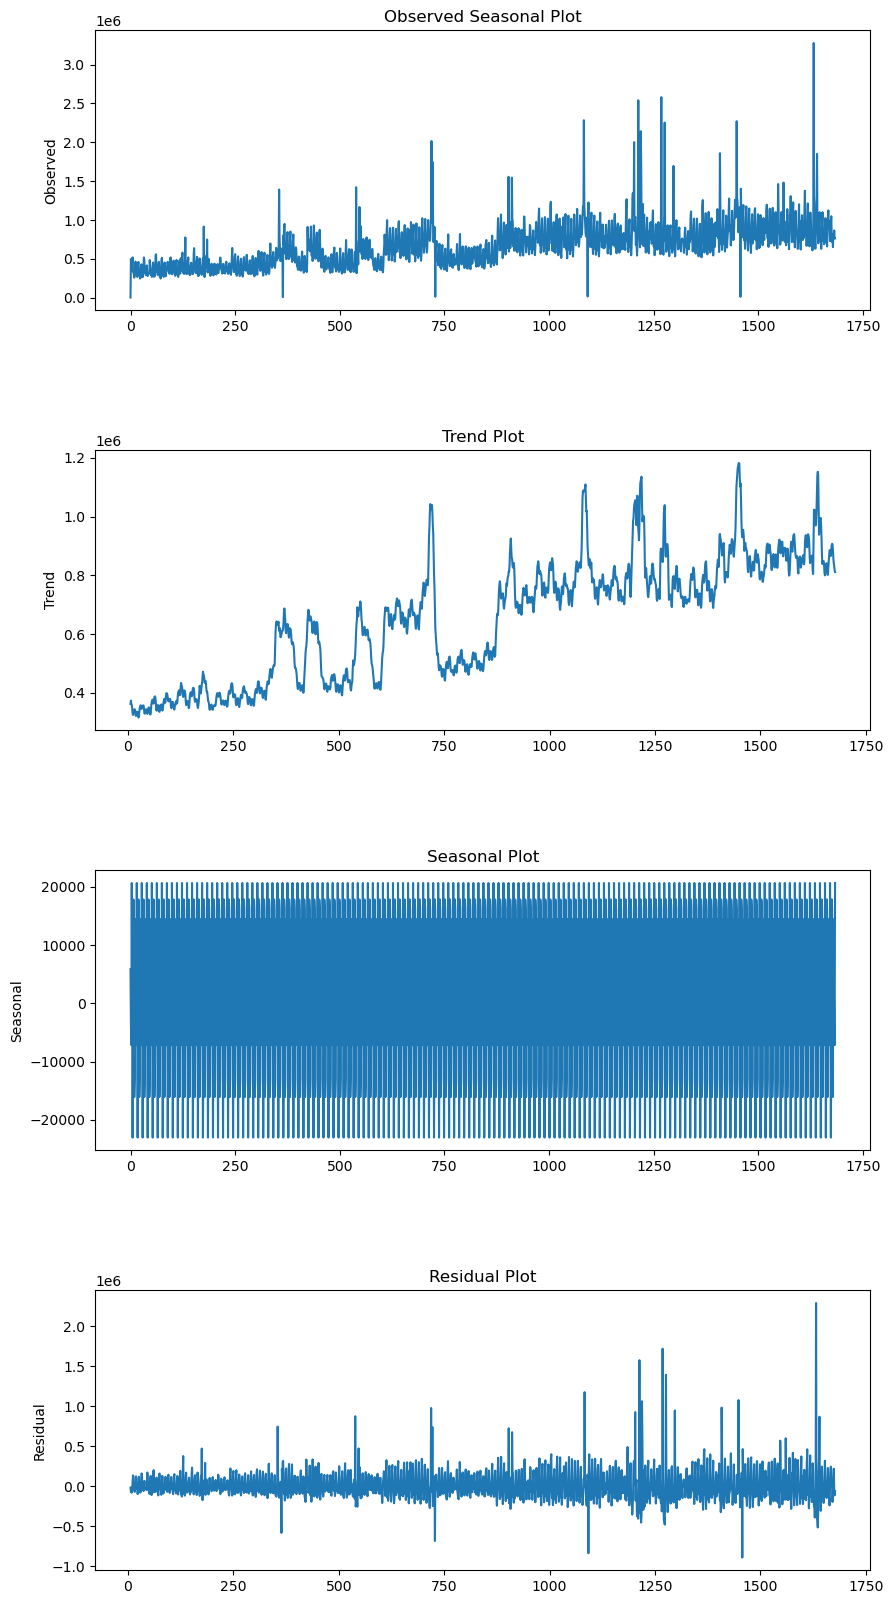

In [329]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(train['sales'], model='additive', period=12)

# create a seasonal plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5) # added space between subplots

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Seasonal Plot')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Plot')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Plot')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Plot')

As we can see, we have some seasonal pattern in the series and a high correlation between the present and past value and we don't have white noise in the series because we have this correlation. But in autocorrelation, if one value was correlated with the present, the next value is also the present. For this, we need to look at Partial Autocorrelations, because this way we eliminate the effects of past values for the next value.

 # Identify Order of AR and MA Terms

 To identify the order of AR and MA terms, you can use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

# Autocorrelation Function

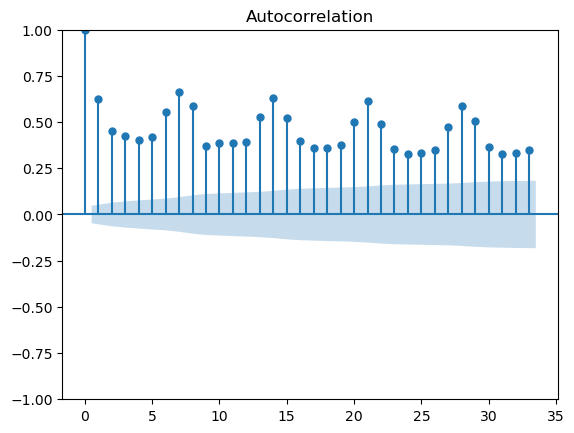

In [330]:
plot_acf(train['sales'], alpha = 0.05);

We have a correlation with 1 and 7 day sales in the past;

# Partial Autocorrelation function

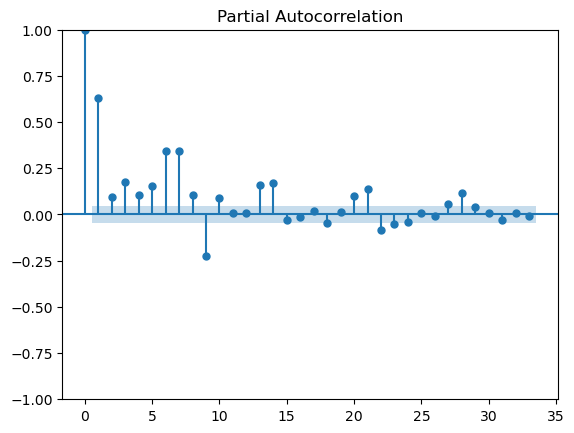

In [331]:
plot_pacf(train['sales'], alpha = 0.05);

As we can see, we have a seasonal pattern on day 5,6 and 15, 16, that is, for every 5 days we have an increase in sales.

In [332]:
p_value_adfuller = adfuller(train['sales'])[1]
print(p_value_adfuller)

0.04178984005432005


# Fit ARIMA Model

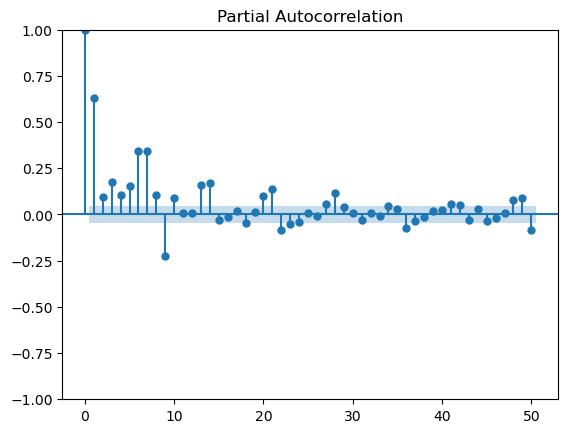

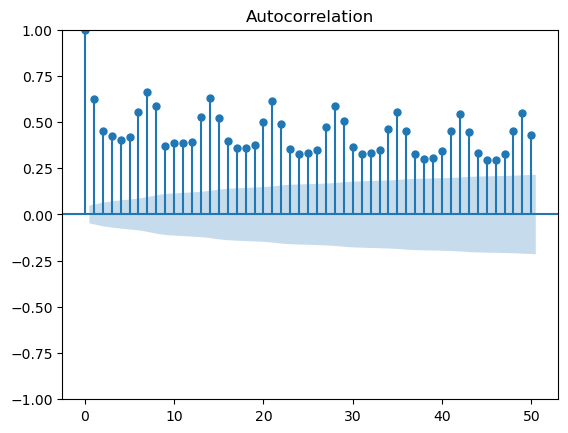

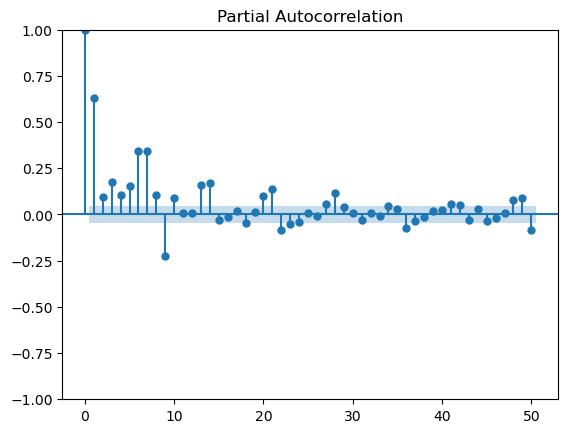

In [333]:
import statsmodels.api as sm

p = 1
d = 1
q = 1

train_np = train['sales'].values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))


# Define the order of differencing, AR, and MA terms
model_fit = model.fit()

# Plot ACF and PACF
plot_acf(train_np, lags=50)
plot_pacf(train_np, lags=50)

As we can see, only dif_onpromotion has a low level of correlation with sales. We made a difference because sometimes correlation necessarily means that they are correlated.


# Model Diagnostics

In [334]:
train['date'] = pd.to_datetime(train['date'])
train = train.set_index('date')

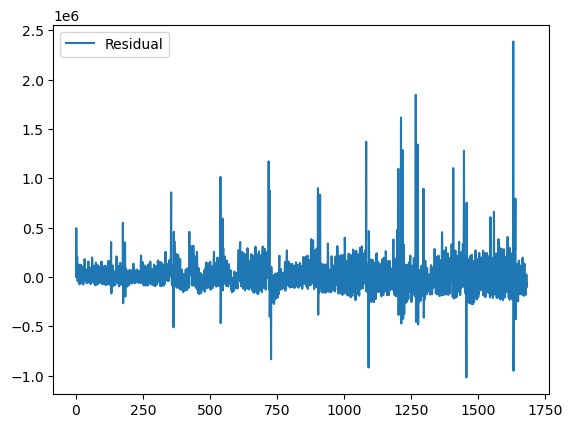

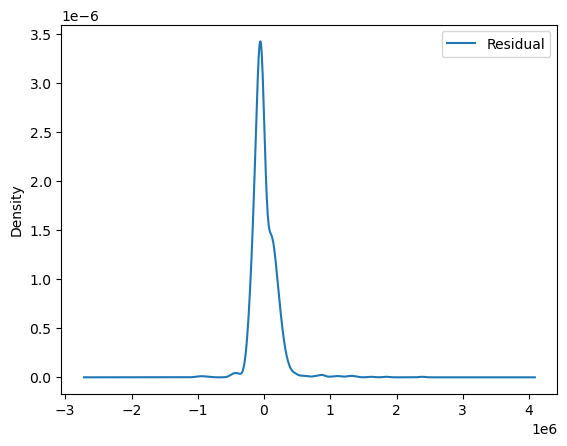

           Residual
count  1.684000e+03
mean   5.818311e+03
std    1.966088e+05
min   -1.016637e+06
25%   -9.324641e+04
50%   -3.202403e+04
75%    9.393068e+04
max    2.385657e+06


In [335]:
# Model diagnostics
residuals = pd.DataFrame(model_fit.resid, columns=['Residual'])
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

**Summary of the Model**

In [336]:
# define the order of differencing, AR, and MA terms
p = 1
d = 1
q = 1

# extract the target variable as a numpy array
train_np = train['sales'].values.astype('float64')

# fit the ARIMA model
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

# train the ARIMA model
results = model.fit()

# print the summary of the trained model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1684
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22918.921
Date:                Thu, 04 May 2023   AIC                          45843.843
Time:                        05:26:19   BIC                          45860.128
Sample:                             0   HQIC                         45849.875
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3068      0.017     18.557      0.000       0.274       0.339
ma.L1         -0.9574      0.007   -128.980      0.000      -0.972      -0.943
sigma2      4.734e+10   9.47e-15      5e+24      0.0

Here SARIMAX Results means (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)

# Forecasting 

In [338]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming your training data is stored in a DataFrame called "train"
y_train = train['sales']
X_train = train['onpromotion']

# Define and fit the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_fit = model.fit()

# Make predictions on the training data
y_pred = model_fit.predict(start=train.index[0], end=train.index[-1], exog=X_train)

# Calculate mean absolute error and mean squared error
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)

print('MAE:', mae)
print('MSE:', mse)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35754D+01    |proj g|=  5.03662D-02


 This problem is unconstrained.



At iterate    5    f=  1.35637D+01    |proj g|=  5.71173D-03

At iterate   10    f=  1.35635D+01    |proj g|=  5.92136D-04

At iterate   15    f=  1.35630D+01    |proj g|=  6.43073D-03

At iterate   20    f=  1.35625D+01    |proj g|=  5.54343D-04

At iterate   25    f=  1.35624D+01    |proj g|=  1.61908D-03

At iterate   30    f=  1.35623D+01    |proj g|=  8.58282D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   8.583D-06   1.356D+01
  F =   13.562336067095263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
MAE: 77501.84159515066
MSE: 18170030523.275894


# Predicting the Sales for the next year

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38525D+01    |proj g|=  4.13850D-01

At iterate    5    f=  1.36008D+01    |proj g|=  1.90536D-02


 This problem is unconstrained.



At iterate   10    f=  1.35932D+01    |proj g|=  3.12962D-02

At iterate   15    f=  1.35844D+01    |proj g|=  4.87700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   6.430D-06   1.358D+01
  F =   13.584290266270864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


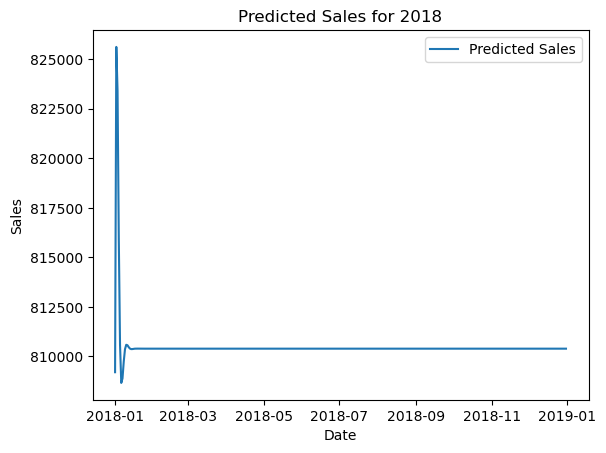

In [339]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train ARIMA model on sales data
model = SARIMAX(train['sales'], order=(2,1,2))
model_fit = model.fit()

# Predict sales for the next year
predicted_sales = model_fit.forecast(steps=365)

# Create a list of dates for the year 2018
dates_2018 = pd.date_range(start='2018-01-01', end='2018-12-31')

# Plot the predicted sales data for the year 2019
plt.plot(dates_2018, predicted_sales, label='Predicted Sales')

# Set the plot title and axis labels
plt.title('Predicted Sales for 2018')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


<details>
    <summary>
        <font color = 'red'><h1>CONCLUSION</h1></font>
    </summary>
    <p>

From the above ARIMA Model we can see 

1) The output suggests that the model converged after 30 iterations. The final function value (F) is 13.5623.

2) The machine precision used in the optimization is 2.220D-16.

3) The mean absolute error (MAE) is 77501.8416, and the mean squared error (MSE) is 18170030523.2759.

4) The plot shows the comparison between actual and predicted sales using an ARIMA model.It is evident that the model has captured the trend and        seasonality in the data, as the predicted sales follow a similar pattern as the actual sales. 

5) The overall performance of the model appears to be good, indicating that it can be used for forecasting sales in the future with a reasonable degree of accuracy.
        
    </p>